In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.utils import plot_model

In [2]:
!nvidia-smi

Fri May  7 10:30:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla M60           On   | 00000000:00:1E.0 Off |                    0 |
| N/A   38C    P8    14W / 150W |      0MiB /  7618MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
base_dir = './findog2'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(
        rescale=1/255,    
        rotation_range=40,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
     rescale=1/255
)

train_generator = train_datagen.flow_from_directory(
    train_dir, 
#     color_mode='grayscale',
    target_size=(200,200),
    batch_size=100,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
#     color_mode='grayscale',
    target_size=(200,200),
    batch_size=100,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    validation_dir,
#     color_mode='grayscale',
    target_size=(200,200),
    batch_size=100,
    class_mode='categorical'
)

Found 15364 images belonging to 87 classes.
Found 3797 images belonging to 87 classes.
Found 0 images belonging to 87 classes.


# 전이 학습

In [4]:
# pretrained network
model_base = InceptionResNetV2(include_top=False, 
                            weights='imagenet', input_shape=(200,200,3))
# model_base의 weight학습을 동결
model_base.trainable=False

model_base.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 99, 99, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 99, 99, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 99, 99, 32)   0           batch_normalization[0][0]        
________________________________________________________________________________

In [5]:
model = Sequential()

# pretrained network를 우리의 모델 앞에 추가
model.add(model_base)

model.add(Flatten())

model.add(Dropout(0.5))

model.add(Dense(87, activation='softmax'))

model.summary()

model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
flatten (Flatten)            (None, 24576)             0         
_________________________________________________________________
dropout (Dropout)            (None, 24576)             0         
_________________________________________________________________
dense (Dense)                (None, 87)                2138199   
Total params: 56,474,935
Trainable params: 2,138,199
Non-trainable params: 54,336,736
_________________________________________________________________


# Fine Tuning

In [6]:
'''
model_base.trainable=True

# 상위 layer 동결해제
for layer in model_base.layers:
    if layer.name in ['top_conv','block7b_project_conv', 'block7b_se_expand', 'block7b_se_reduce']:
        layer.trainable=True
    else:
        layer.trainable=False

# learning_rate 더 작게 설정
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy',
              metrics=['accuracy'])
'''

"\nmodel_base.trainable=True\n\n# 상위 layer 동결해제\nfor layer in model_base.layers:\n    if layer.name in ['top_conv','block7b_project_conv', 'block7b_se_expand', 'block7b_se_reduce']:\n        layer.trainable=True\n    else:\n        layer.trainable=False\n\n# learning_rate 더 작게 설정\nmodel.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy',\n              metrics=['accuracy'])\n"

In [7]:
'''
plot_model(model, show_shapes=True, rankdir='TB', dpi=96, 
           to_file='./models/융합프로젝트.png')'''

"\nplot_model(model, show_shapes=True, rankdir='TB', dpi=96, \n           to_file='./models/융합프로젝트.png')"

In [8]:
history = model.fit(train_generator, steps_per_epoch=150, epochs=30,
                    validation_data=validation_generator, validation_steps=37)

Epoch 1/30
150/150 [==============================] - 209s 1s/step - loss: 5.4003 - accuracy: 0.1120 - val_loss: 2.8756 - val_accuracy: 0.3289
Epoch 2/30
150/150 [==============================] - 176s 1s/step - loss: 3.7461 - accuracy: 0.2709 - val_loss: 2.7041 - val_accuracy: 0.3622
Epoch 3/30
150/150 [==============================] - 175s 1s/step - loss: 3.4459 - accuracy: 0.3048 - val_loss: 2.5868 - val_accuracy: 0.3989
Epoch 4/30
150/150 [==============================] - 176s 1s/step - loss: 3.3331 - accuracy: 0.3247 - val_loss: 2.4537 - val_accuracy: 0.4111
Epoch 5/30
150/150 [==============================] - 176s 1s/step - loss: 3.2190 - accuracy: 0.3326 - val_loss: 2.3661 - val_accuracy: 0.4351
Epoch 6/30
150/150 [==============================] - 175s 1s/step - loss: 3.0716 - accuracy: 0.3621 - val_loss: 2.4335 - val_accuracy: 0.4230
Epoch 7/30
150/150 [==============================] - 176s 1s/step - loss: 3.0878 - accuracy: 0.3567 - val_loss: 2.4284 - val_accuracy: 0.4373

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


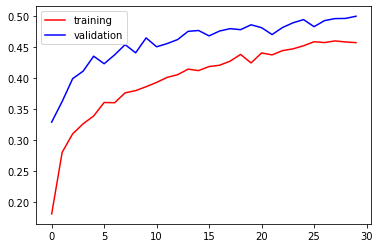

In [9]:
# history 객체 확인
print(history.history.keys())

train_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']

train_loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.plot(train_acc, color='r', label='training')
plt.plot(validation_acc, color='b', label='validation')
plt.legend()
#plt.savefig('./models/InceptionResNetV2_1/InceptionResNetV2_1-1_acc.jpg')
plt.show()

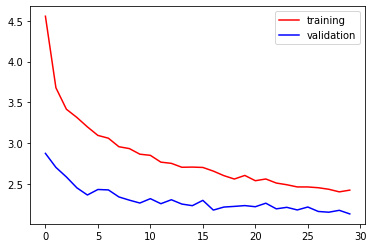

In [10]:
plt.plot(train_loss, color='r', label='training')
plt.plot(validation_loss, color='b', label='validation')
plt.legend()
#plt.savefig('./models/InceptionResNetV2_1/InceptionResNetV2_1-1_val.jpg')
plt.show()

In [11]:
result = model.evaluate(validation_generator)
print(np.round(result, 4))

38/38 [==============================] - 37s 972ms/step - loss: 2.2052 - accuracy: 0.4907
[2.2052 0.4907]


In [12]:
#model.save('./models/InceptionResNetV2_1/InceptionResNetV2_1-1.h5')

In [ ]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(t_data_test,
                      sess.run(tf.argmax(H,1), feed_dict={X:norm_x_data_test})))